<h1>Weather on Mars - Next Day Prediction</h1>
<h2>Prediction of temperature based on empirical data collected by Curiosity Mars Rover</h2>


In [ ]:
runLocallyOrOnDrive = 'Drive' # 'Drive' or 'Local'
#if 'Local' change the paths below to local paths e.g.  r'C:/Users/..'

In [ ]:
#@title Connect to Google Drive if runLocallyOrOnDrive=='Drive'
if runLocallyOrOnDrive == "Drive":
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@title Change these file paths to your respective
#Google drive folder, but it can also be local e.g. on your C-disk
if runLocallyOrOnDrive == 'Local':
    loadModelPath = r'/content/../model.json' 
    saveModelPathH5 = r'/content/../model.h5'  
    
elif runLocallyOrOnDrive == 'Drive': 
    saveModelPath = r'/content/../model.json' 
    saveModelPathH5 = r'/content/../model.h5'

In [ ]:
#@title Import libraries
# # If you want to loads file, upload to drive and run the following
import urllib, json

# import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import timedelta  

from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#@title Functions: Load Data
# returns the (average) weather data for a top level key [sol] from [sol_keys]
def findAtAndPre(dictionary, key):
  value = dictionary.get(key)
  return {'terrestrial_date': value.get('First_UTC')[:10], 'Low': value.get('AT')['mn'], 'High': value.get('AT')['mx']}

def loadRecentNDaysOfData(): 
  # returns the data of the latest 7 days
  apiUrl = 'https://api.nasa.gov/insight_weather/?api_key=DEMO_KEY&feedtype=json&ver=1.0'
  jsonApi = json.loads(urllib.request.urlopen(apiUrl).read())
  dfApi = pd.DataFrame({key: findAtAndPre(jsonApi, key) for key in jsonApi.get('sol_keys')})
  return dfApi

In [ ]:
data = loadRecentNDaysOfData().T
data['avg_temp'] = data[['Low', 'High']].mean(axis=1)
data['terrestrial_date']=pd.to_datetime(data['terrestrial_date'])
df_avg_temp=pd.DataFrame(list(data['avg_temp']), index=data['terrestrial_date'], columns=['temp'])
df_avg_temp.fillna(data['avg_temp'].mean(),inplace=True)

data

,terrestrial_date,Low,High,avg_temp
669,2020-10-13,-95.63,-15.85,-55.7400
670,2020-10-14,-95.821,-15.826,-55.8235
671,2020-10-15,-95.959,-8.545,-52.2520
672,2020-10-16,-96.828,-6.506,-51.6670
673,2020-10-17,-96.654,-9.915,-53.2845
674,2020-10-18,-96.011,-7.439,-51.7250
675,2020-10-19,-96.872,-15.908,-56.3900


In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scData =scaler.fit_transform(df_avg_temp)
inputs = []
inputs.append(scData)

In [ ]:
inputs=np.asanyarray(inputs)
tst_x=inputs

In [ ]:
#@title Load Model JSON for testing
#serialize mode to JSON
from tensorflow.keras.models import model_from_json
json_file =  open(loadModelPath,"r")
model_json = json_file.read()
json_file.close()
model_fromDisk = model_from_json(model_json)

#load weights into the new model 
model_fromDisk.load_weights(loadModelPathH5)
print("loaded from disk")

loaded from disk


Here is tomorrows average temperature on Mars

In [ ]:
prediction = scaler.inverse_transform(model_fromDisk.predict(tst_x))
prediction_date = max(pd.to_datetime(data['terrestrial_date']))+ timedelta(days=1)

datalist = [[prediction_date,\
            data["Low"].mean(),\
            data["High"].mean(),\
            prediction[0][0]]]
  
# Create the pandas DataFrame 
df_new = pd.DataFrame(datalist, columns = ['terrestrial_date', 'Low','High','avg_temp']) 
df_with_prediction = data.append([df_new],ignore_index=True)

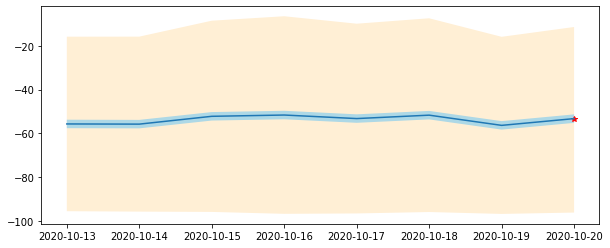

In [ ]:
# show data of past 7 days plus prediction day
data_1 = df_with_prediction.set_index('terrestrial_date')
dayRange = data_1.index.to_list()
meanTemperature = data_1['avg_temp']
std = data_1['avg_temp'].std()
lower = (meanTemperature-std).to_list()
upper = (meanTemperature+std).to_list()
high = data_1['High'].to_list()
low = data_1['Low'].to_list()

plt.figure(figsize=(10,4))

plt.plot(prediction_date, prediction,'r*')

plt.plot(dayRange, meanTemperature)

# first fill between min and max temps
plt.fill_between(dayRange, low, high, facecolor='papayawhip')

# then also fill std-range (perhaps from archive data?)
plt.fill_between(dayRange, lower, upper, facecolor='lightblue')